# Installing and importing dependencies

In [1]:
!pip install openpyxl
!pip install pandas
!pip install numpy
!pip install rdkit

In [16]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from rdkit.Chem import DataStructs

Function that will be used to check that no "na" values appear:

In [3]:
def check_no_na(data):
    if data.isna().sum().eq(0).all():
        print("Success: No NA values found.")
        return
    print("Warning: NA values found.")

# Importing the dataset

In [4]:
df_raw=pd.read_excel("denmark.xlsx")
df_raw.head()

,Catalyst,Imine,Thiol,Output
0,O=P1(O)OC2=C(C3=C(C4CCCCC4)C=C(C5CCCCC5)C=C3C6...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1C,3.134625
1,O=P1(O)OC2=C(C3=CC(C4=C(C)C=C(C)C=C4C)=CC(C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=C(OC)C=C1,1.531803
2,O=P1(O)OC2=C(C3=CC=C(OC)C=C3)C=C4C(C=CC=C4)=C2...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1,1.074991
3,O=P1(O)OC2=[C@]([C@]3=C(Cl)C=C(Cl)C=C3Cl)C=C4C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=CC=C1C,1.334823
4,O=P1(O)OC2=C(C3=C(C=CC4=CC=CC(C=C5)=C46)C6=C5C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1=CC=CC=C1,1.743658


# Looking at the data

### Target values

First of all, it would be important to look at how output values are distributed:

In [5]:
df_raw.describe()

,Output
count,1075.000000
mean,0.987658
std,0.700524
min,-0.419378
25%,0.473820
50%,1.050757
75%,1.370104
max,3.134625


One could also look at the distribution of the target variable:

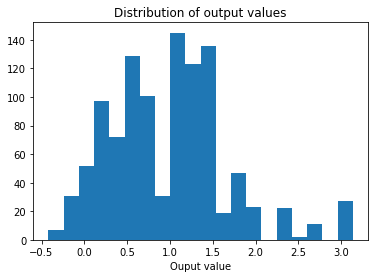

In [6]:
plt.hist(x=df_raw["Output"], bins=20);
plt.title("Distribution of output values")
plt.xlabel("Ouput value");

### Features

Are there any "na" values?

In [7]:
check_no_na(df_raw)

Success: No NA values found.


How many different molecules are there?

In [8]:
unique_catalysts=df_raw["Catalyst"].unique()
unique_imines=df_raw["Imine"].unique()
unique_thiols=df_raw["Thiol"].unique()
pd.DataFrame({"Unique Catalysts": [unique_catalysts.shape[0]], "Unique Imines": [unique_imines.shape[0]], "Unique Thiols": [unique_thiols.shape[0]]})

,Unique Catalysts,Unique Imines,Unique Thiols
0,43,5,5


Here, one could use One-hot encoding for the Imines and Thiols. This idea was discarded since in the case another Thiol or Imine is added, one would have to retrain the model instead of being able to fine-tune it. 

Show 3 random different Catalysts:

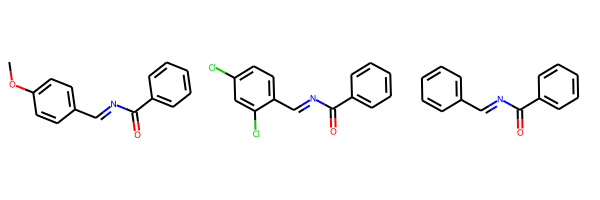

In [9]:
mol_list=[]
unique_molecules=df_raw["Imine"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Imine:

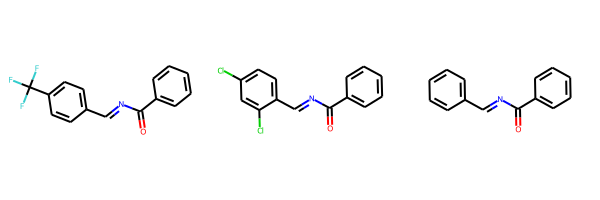

In [10]:
mol_list=[]
unique_molecules=df_raw["Imine"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Thiol:

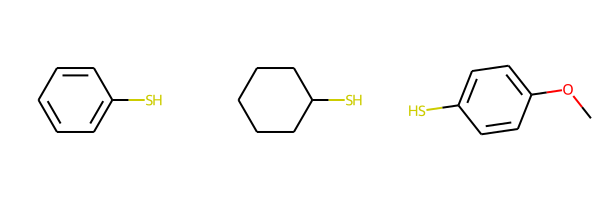

In [11]:
mol_list=[]
unique_molecules=df_raw["Thiol"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules, index)
Draw.MolsToGridImage(mol_list)

# Preprocessing

### Creating RDKit molecules

Translating the "Catalyst", the "Imine" and the "Thiol" columns from SMILES to a RDKit molecule:

In [38]:
df_X=df_raw[["Catalyst", "Imine", "Thiol"]].applymap(Chem.MolFromSmiles)
df_y=df_raw["Output"]
df_X.head()

,Catalyst,Imine,Thiol
0,<rdkit.Chem.rdchem.Mol object at 0x7f4ef71d3170>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef7200670>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef7169a30>
1,<rdkit.Chem.rdchem.Mol object at 0x7f4ef71d30d0>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef72004e0>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef7169990>
2,<rdkit.Chem.rdchem.Mol object at 0x7f4ef71d31c0>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef7169940>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef717f2b0>
3,<rdkit.Chem.rdchem.Mol object at 0x7f4ef71d3210>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef71698f0>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef717f260>
4,<rdkit.Chem.rdchem.Mol object at 0x7f4ef71d3260>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef7169ad0>,<rdkit.Chem.rdchem.Mol object at 0x7f4ef717f210>


In [39]:
fp=AllChem.GetMorganFingerprintAsBitVect(df_X["Catalyst"][2],2)
arr = np.zeros((0,), dtype=np.int8)
DataStructs.ConvertToNumpyArray(fp,arr)
list(map(lambda x:x-1, arr))
arr

array([0, 1, 0, ..., 0, 0, 0], dtype=int8)

In [50]:
def morgan_fp(X):
    fp=AllChem.GetMorganFingerprintAsBitVect(X,2)
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr
new_X=np.array([])
for row in df_X.to_numpy():
    new_row=np.array([])
    for element in row:
        fp=morgan_fp(element)
        new_row=np.append(new_row, fp, 0)
    new_row=new_row.reshape((df_X.shape[1],-1))
    new_X=np.append(new_X, new_row)
    new_X=new_X.reshape([-1, new_row.shape[0], new_row.shape[1]])
new_X

array([[[0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

Verifying that all the smiles transfered successfuly. The RDKit documentaton states:

>or None on failure:
>
>> ```m = Chem.MolFromMolFile('data/invalid.mol')```
>>
>> ```m is None```
>
>True

So the "na" instances are counted and should be 0 if no problems were encountered:

In [ ]:
check_no_na(df_X)

For later on, Morgan fingerprints will be used. In order to try and search for the best parameters for these molecules, the atom radius and the number of bits used will be searched using grid search.

### Creating a Pipeline

Here, in order to later use SKlearn's ```CVGridSearch```, a custom pipeline will be built in order to be able to find the ideal hyperparameters. First step: creating a custom transformer to be used in the pipeline, in order to use RDKit's ```GetMorganFingerprint```'s parameters as hyperparameters for the model.

In [ ]:
class fingerprinter(BaseEstimator, TransformerMixin):
    def __init__(self, n_bits=1024, n_atom=2):
        self.n_bits = n_bits
        self.n_atom = n_atom
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        morgan_fp= lambda x: AllChem.GetMorganFingerprint(x, self.n_atom, nBits=self.n_bits)
        encoder=np.vectorize(morgan_fp)
        X=encoder(X)
        return X
        

Now, the first pipeline can be created:

In [ ]:
pipe = Pipeline([( "fingerprinter" , fingerprinter()),
                       ("ridge",Ridge())])

In [ ]:
param_grid={"fingerprinter__n_bits":np.logspace(2, 4, 3, dtype=int), "fingerprinter__n_atom":np.arange(1, 3, 1), "fingerprinter__n_bits":np.logspace(2, 4, 3, dtype=int), "ridge__alpha":np.logspace(0, 3, 10)}

In [ ]:
param_grid

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df_X.to_numpy(), df_y.to_numpy(), train_size=0.75)

In [ ]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

idea: use qsar fingerprints: http://www.qsar4u.com/files/qsar_rdkit_tutorial/qsar-rdkit.html

idea: https://pubs.acs.org/doi/10.1021/acs.jcim.7b00616

why morgan? http://practicalcheminformatics.blogspot.com/2020/03/benchmarking-one-molecular-fingerprint.html